In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
model_seq_info = pd.read_parquet('../data3/interim/model_seq_info.pq')
defense_predictions = pd.read_parquet('../data3/interim/cv_predictions_defense_predictor.pq')

In [3]:
merged_seq_info = model_seq_info.merge(defense_predictions, how='inner', 
                                       on='seq_id')

In [4]:
merged_seq_info['log_odds'] = np.log(merged_seq_info['prediction']/(1-merged_seq_info['prediction']))

In [5]:
merged_seq_info['log_odds'].min()

-23.574162916908563

In [6]:
merged_seq_info['log_odds'].max()

19.71749793404244

In [7]:
log_odds_edges = np.arange(-38.5, 28, 0.5)

In [8]:
window = 2

In [9]:
precision_list = list()

In [10]:
for left_edge in tqdm(log_odds_edges, position=0):
    relevant_predictions = merged_seq_info[merged_seq_info['log_odds'].between(left_edge, left_edge + window)]
    fold_precision = (relevant_predictions.groupby('test_fold')
                      .agg(precision=('defensive', 'mean'), 
                           n_points=('seq_id', 'nunique'))
                      .reset_index())
    fold_precision['mid_pt'] = left_edge + window/2
    precision_list.append(fold_precision)
    

100%|██████████| 133/133 [00:01<00:00, 96.52it/s] 


In [11]:
cat_precision = pd.concat(precision_list)

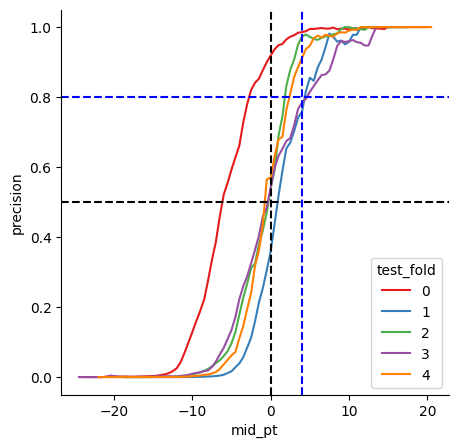

In [12]:
plt.subplots(figsize=(5,5))
sns.lineplot(data=cat_precision, x='mid_pt', y='precision', hue='test_fold', palette='Set1')
sns.despine()
plt.axvline(x=0, linestyle='dashed', 
            color='black')
plt.axhline(y=0.5, linestyle='dashed', 
            color='black')
plt.axvline(x=4, linestyle='dashed', 
            color='blue')
plt.axhline(y=0.8, linestyle='dashed', 
            color='blue')